OpenGAN: Open-Set Recognition via Open Data Generation
================
**Supplemental Material for ICCV2021 Submission**


In this notebook is for demonstrating open-set semantic segmentation, especially for training in this task.

# To Do
Retrain 

Link to TinyImageNet: 
http://cs231n.stanford.edu/tiny-imagenet-200.zip

Shu's suggestions:
Codebase to make TinyImageNet data loader: https://github.com/aimerykong/OpenGAN/blob/main/utils/dataset_tinyimagenet.py

Can we split TinyImageNet into closed-set (e.g., the first 180 classes) and open-set (e.g., the last 20 classes)
closed-train: TinyImageNet's closed-train (e.g., the first 180 classes)
closed-val: TinyImageNet's first half closed-val  (e.g., the first 180 classes)
open-train: one of {SVHN, MNIST}
closed-test: TinyImageNet's second half closed-val-set (e.g., the first 180 classes)
open-test: {TinyImageNet-open-val (last 20 classes), SVHN, MNIST, GaussNoise, uniformnoise, augmentation}

Substitute: ImageNet

If tinyImageNet does not work then I will try resnet18 for k way classification


In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [5]:
!git clone https://github.com/aimerykong/OpenGAN.git
%cd "/content/OpenGAN"

Cloning into 'OpenGAN'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 66 (delta 28), reused 24 (delta 8), pack-reused 0
Unpacking objects: 100% (66/66), done.
/content/OpenGAN


In [6]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math, json, pickle

import argparse, pprint, shutil, logging, time, timeit
from pathlib import Path

from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
# import PIL.Image
from PIL import Image
from io import BytesIO
from skimage import data, img_as_float
from tqdm import tqdm 
from sklearn.metrics import auc, f1_score, precision_recall_curve, roc_auc_score, roc_curve

import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10, MNIST, SVHN
from collections import namedtuple

# from config_HRNet import models
# from config_HRNet import seg_hrnet
# from config_HRNet import config
# from config_HRNet import update_config
# from config_HRNet.modelsummary  import *
# from config_HRNet.utils import *


from utils.dataset_tinyimagenet import *
from utils.dataset_cityscapes import *
from utils.eval_funcs import *

!pip install git+https://github.com/aleju/imgaug.git
import imgaug.augmenters as iaa


import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

# %load_ext autoreload
# %autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-faafronc
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-faafronc
3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]
1.12.1+cu113


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [7]:
# set the random seed
torch.manual_seed(0)


################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model

num_open_training_images = 1000
weight_adversarialLoss = 0.2
project_name = 'demo_step030_OpenGAN_num{}_w{:.2f}'.format(num_open_training_images, weight_adversarialLoss)


device ='cpu'
if torch.cuda.is_available(): 
    device='cuda'
        


ganBatchSize = 64 # 32 fake images
batch_size = 64
newsize = (-1,-1)

total_epoch_num = 20 # total number of epoch in training
insertConv = False    
embDimension = 64
#isPretrained = False
#encoder_num_layers = 18


# Number of channels in the training images. For color images this is 3
nc = 2048 # Might be 720 if resnet18
# Size of z latent vector (i.e. size of generator input)
nz = 64
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1



save_dir = os.path.join(exp_dir, project_name)
if not os.path.exists(exp_dir): os.makedirs(exp_dir)

lr = 0.0001 # base learning rate

num_epochs = total_epoch_num
torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

./exp/demo_step030_OpenGAN_num1000_w0.20


Define model architecture
---------

Here is the definition of the model architecture. 

In [8]:
# Load Outlier Exposure datasets
# Train Datasets
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

mnist_OEtrainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
svhn_OEtrainset = torchvision.datasets.SVHN(root = './data', split = "train", download = True)

# Test Datasets
mnist_OEtestset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
svhn_OEtestset = torchvision.datasets.SVHN(root = './data', split = "test", download = True)

testset = CIFAR10(root='./data', train=False, download=True)
trainset = CIFAR10(root='./data', train=True, download=True)

train_transform = transforms.Compose([
    transforms.ToPILImage(),      
    transforms.RandomHorizontalFlip(), 
    transforms.RandomCrop(32, padding = 4),                  
    transforms.ToTensor(),
    transforms.Normalize((mean), (std))
])


test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
])


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Len of Entire Dataset 30000
Len of Entire Dataset 6000


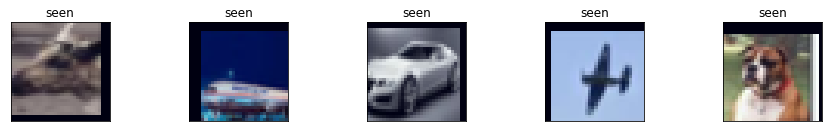

In [9]:
split = 6
class Closed_CIFAR(torch.utils.data.Dataset):
  '''Seen: CIFAR Closed set; Unseen: New Dataset'''

  def __init__(self, CIFAR_dataset, split, transformFunc, OpenSetRec = False):
    '''For CIFAR Only'''
    images, targets = CIFAR_dataset.data, CIFAR_dataset.targets
    img2targets = list(zip(images, targets))
    self.data = list()

    # if OpenSetRec: 
    #   self.data = img2targets
  
    for v in img2targets:
      img, target = v
      if target < split: 
        if OpenSetRec: 
          self.data.append((img, torch.tensor([1, int(target)])))
        else: 
          self.data.append((img, 1)) # 1 is seen

    self.transformFunc = transformFunc
    print("Len of Entire Dataset {}".format(len(self.data)))
    
  def __getitem__(self, i):
    img, target = self.data[i]
    img = self.transformFunc(img)

    return img, target

  def __len__(self):
    return len(self.data)


train_Closed_CIFAR = Closed_CIFAR(trainset, split, train_transform)
train_Closed_CIFARLoader = torch.utils.data.DataLoader(train_Closed_CIFAR, batch_size = 64, shuffle = True)
test_Closed_CIFAR = Closed_CIFAR(testset, split, test_transform)

mixed_classes = ["unseen", "seen"]
train_newDatasetAndCIFARiter = iter(train_Closed_CIFARLoader)
imgs, targets = next(train_newDatasetAndCIFARiter)

imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ''' Choose one way to set titles'''

  '''Option 2:'''
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])


# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Len of Entire Dataset 73257


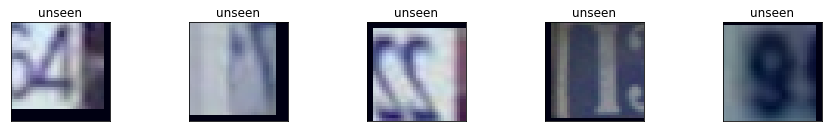

In [10]:
class OpenSetSVHN(torch.utils.data.Dataset):
  '''Seen: CIFAR Closed set; Unseen: New Dataset'''

  def __init__(self, New_dataset_images, New_dataset_targets, transformFunc, OpenSetRec = False, MNIST = False):

    self.data = list()
    img2targets = list(zip(New_dataset_images, New_dataset_targets))

    for v in img2targets: 
      if not OpenSetRec: 
        self.data.append((v[0], 0)) # 0 is unseen
      else: 
        self.data.append((v[0], torch.tensor([0, 0])))
      
    
    self.transformFunc = transformFunc
    self.MNIST = MNIST
    print("Len of Entire Dataset {}".format(len(self.data)))
    
  def __getitem__(self, i):
    img, target = self.data[i]
    if type(img) != np.ndarray and self.MNIST: 
      # MNIST
      img = img.to(float)

      channel_1 = img.unsqueeze(0)
      channel_2 = channel_1.clone()
      channel_3 = channel_1.clone()
      
      img = torch.cat((channel_1, channel_2, channel_3), dim = 0)
      
      img = transforms.Resize(32)(img) 
      
    img = self.transformFunc(img)
    return img, target

  def __len__(self):
    return len(self.data)


train_OpenSetSVHN = OpenSetSVHN(torch.from_numpy(svhn_OEtrainset.data), torch.from_numpy(svhn_OEtrainset.labels), train_transform)
train_OpenSetSVHNLoader = torch.utils.data.DataLoader(train_OpenSetSVHN, batch_size = 16, shuffle = True)

mixed_classes = ["unseen", "seen"]
train_newDatasetAndCIFARiter = iter(train_OpenSetSVHNLoader)
imgs, targets = next(train_newDatasetAndCIFARiter)

imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ''' Choose one way to set titles'''

  '''Option 2:'''
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])


# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [11]:
class OnlyNoiseData(torch.utils.data.Dataset): 
  
  def __init__(self, img_dim, noise_type, current_len, imgs, targets, split, transformFunc): 
    
    self.datatypes = list()
    self.datatypes.extend(["NOISE"] * 100)
    self.noise_type = noise_type
    self.current_len = current_len

  def __getitem__(self, idx): 

    # adjust mu and sigma accordingly (that's why I created 2 variables)
    print(idx)
    datatype = self.datatypes[idx]
    if self.noise_type == "normal": 
      mu, sigma = 0, 1
      return torch.from_numpy(np.random.normal(mu, sigma, size = self.img_dim)), 0
    elif self.noise_type == "uniform": 
      mu, sigma = 0, 1
      return torch.from_numpy(np.random.uniform(mu, sigma, size = self.img_dim)), 0
  
  def __len__(self): 

    return self.current_len * 2

batch_size = 32

open_normalDisData = OnlyNoiseData((3, 32, 32), "normal", 70000, testset.data, testset.targets, split, test_transform)
open_normalDisLoader = torch.utils.data.DataLoader(open_normalDisData, batch_size = batch_size, shuffle = True)
print("Len of NoiseLoader: {}".format(len(open_normalDisData)))

noiseIter = iter(open_normalDisLoader)
imgs, targets = next(noiseIter)
imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

print("Max {}".format(imgs.max()))
print("Min {}".format(imgs.min()))

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Len of NoiseLoader: 140000
89287


IndexError: ignored

Len of CIFAR: 6000
Len of Entire Dataset 12000
Len of CIFAR: 6000
Len of Entire Dataset 12000


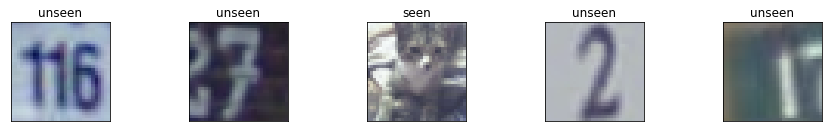

In [12]:
split = 6
class NewDataset_and_CIFAR(torch.utils.data.Dataset):
  '''Seen: CIFAR Closed set; Unseen: New Dataset'''

  def __init__(self, CIFAR_dataset, New_dataset_images, New_dataset_targets, split, transformFunc, OpenSetRec = False, MNIST = False):
    '''For CIFAR Only'''
    images, targets = CIFAR_dataset.data, CIFAR_dataset.targets
    img2targets = list(zip(images, targets))
    self.data = list()

    # if OpenSetRec: 
    #   self.data = img2targets
  
    for v in img2targets:
      img, target = v
      if target < split: 
        if OpenSetRec: 
          self.data.append((img, torch.tensor([1, int(target)])))
        else: 
          self.data.append((img, 1)) # 1 is seen
    
    print("Len of CIFAR: {}".format(len(self.data)))
    

    '''For New Dataset Only'''
    img2targets = list(zip(New_dataset_images, New_dataset_targets))[:(len(self.data))]

    for v in img2targets: 
      if not OpenSetRec: 
        self.data.append((v[0], 0)) # 0 is unseen
      else: 
        self.data.append((v[0], torch.tensor([0, 0])))
      
    
    self.transformFunc = transformFunc
    self.MNIST = MNIST
    print("Len of Entire Dataset {}".format(len(self.data)))
    
  def __getitem__(self, i):
    img, target = self.data[i]
    if type(img) != np.ndarray and self.MNIST: 
      # MNIST
      img = img.to(float)

      channel_1 = img.unsqueeze(0)
      channel_2 = channel_1.clone()
      channel_3 = channel_1.clone()
      
      img = torch.cat((channel_1, channel_2, channel_3), dim = 0)
      
      img = transforms.Resize(32)(img) 
      
    img = self.transformFunc(img)
    return img, target
    # img, target = self.data[i]
    # img = self.transformFunc(img)
    # return img, target

  def __len__(self):
    return len(self.data)


# train_newDatasetAndCIFAR = NewDataset_and_CIFAR(trainset, torch.from_numpy(svhn_OEtrainset.data), torch.from_numpy(svhn_OEtrainset.labels), split, train_transform)
# train_newDatasetAndCIFARLoader = torch.utils.data.DataLoader(train_newDatasetAndCIFAR, batch_size = batch_size, shuffle = True)

test_newDatasetAndCIFAR = NewDataset_and_CIFAR(testset, torch.from_numpy(svhn_OEtestset.data), torch.from_numpy(svhn_OEtestset.labels), split, test_transform)
test_newDatasetAndCIFARLoader = torch.utils.data.DataLoader(test_newDatasetAndCIFAR, batch_size = batch_size, shuffle = True)

'''MNIST combined dataset with CIFAR closed testset'''

test_MNISTAndCIFAR = NewDataset_and_CIFAR(testset, mnist_OEtestset.data, mnist_OEtestset.targets, split, test_transform, MNIST = True)
test_MNISTAndCIFARLoader = torch.utils.data.DataLoader(test_MNISTAndCIFAR, batch_size = batch_size, shuffle = True)

mixed_classes = ["unseen", "seen"]
train_newDatasetAndCIFARiter = iter(test_newDatasetAndCIFARLoader)
imgs, targets = next(train_newDatasetAndCIFARiter)

imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ''' Choose one way to set titles'''

  '''Option 2:'''
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])


# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Len of NoiseLoader: 200
Len of UniformLoader: 200
Max 1.0
Min 0.0


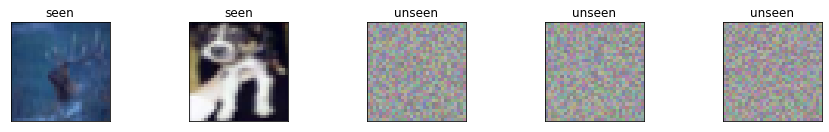

In [13]:
mixed_classes = ["unseen", "seen"]
class PureNoiseData(torch.utils.data.Dataset): 
  
  def __init__(self, img_dim, noise_type, current_len, imgs, targets, split, transformFunc): 
    self.img_dim = img_dim
    assert type(self.img_dim) == tuple
    self.current_len = current_len
    indices = []
    for i, target in enumerate(targets): 
      if target < split: 
        indices.append(i)
    
    indices = indices[:current_len]
    self.imgs= list()
    self.datatypes = list()
    for ii in indices: 
      self.imgs.append(imgs[ii])
      self.datatypes.append("CIFAR")
    
    self.datatypes.extend(["NOISE"] * 100)

    self.noise_type = noise_type
    self.transformFunc = transformFunc

  def __getitem__(self, idx): 

    # adjust mu and sigma accordingly (that's why I created 2 variables)
    datatype = self.datatypes[idx]
    if datatype == "NOISE": 
      if self.noise_type == "normal": 
        mu, sigma = 0, 1
        return torch.from_numpy(np.random.normal(mu, sigma, size = self.img_dim)), 0
      elif self.noise_type == "uniform": 
        mu, sigma = 0, 1
        return torch.from_numpy(np.random.uniform(mu, sigma, size = self.img_dim)), 0
    elif datatype == "CIFAR": 
      img = self.imgs[idx]
      img = self.transformFunc(img)
      return img, 1
    else: 
      raise ValueError("Internal Error- Refactor Code")
  
  def __len__(self): 

    return self.current_len * 2


batch_size = 32

normalDisData = PureNoiseData((3, 32, 32), "normal", 100, testset.data, testset.targets, split, test_transform)
normalDisLoader = torch.utils.data.DataLoader(normalDisData, batch_size = batch_size, shuffle = True)
print("Len of NoiseLoader: {}".format(len(normalDisData)))

uniformDisData = PureNoiseData((3, 32, 32), "uniform", 100, testset.data, testset.targets, split, test_transform)
print("Len of UniformLoader: {}".format(len(uniformDisData)))
uniformDisLoader = torch.utils.data.DataLoader(uniformDisData, batch_size = batch_size, shuffle = True)

noiseIter = iter(uniformDisLoader)
imgs, targets = next(noiseIter)
imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

print("Max {}".format(imgs.max()))
print("Min {}".format(imgs.min()))

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

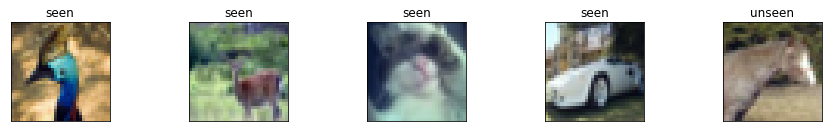

In [14]:
class MixedCIFAR(torch.utils.data.Dataset):
    def __init__(self, data, targets, split, transformFunc):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        img2targets = list(zip(data, targets))
        self.data = list()

        
        for v in img2targets:
          image, target = v
          if target < split: 
            self.data.append((image, 1))
          else: 
            self.data.append((image, 0))
        
        self.transformFunc = transformFunc

    def __getitem__(self, i):

       img, target = self.data[i]
       img = self.transformFunc(img)
       return img, target

    def __len__(self):
        return len(self.data)

test_mixedCIFAR = MixedCIFAR(testset.data, testset.targets, split, transformFunc = test_transform)
test_mixedCIFARLoader = torch.utils.data.DataLoader(test_mixedCIFAR, batch_size = batch_size, shuffle = True)

mixed_classes = ["unseen", "seen"]
mixedCIFARiter = iter(test_mixedCIFARLoader)
imgs, targets = next(mixedCIFARiter)

images = imgs.numpy()
images -= images.min() 
images /= images.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [15]:
transforms_noisyOE = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.pillike.EnhanceContrast(), 
    iaa.GaussianBlur(sigma=(0.1, 2)), 
    iaa.Rain(speed=(0.1, 0.3))
])

# transforms_noisyOE = transforms.Compose([
#    transforms.ToPILImage(), 
#    transforms.ColorJitter(contrast = 0.3),
#    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 5)), 
#    transforms.ToTensor(),
#   transforms.Normalize((mean), (std))
# ])

closed_set_heavy_Transforms = SplitCIFAR(testset.data, testset.targets, split, "train", transforms_noisyOE, iaa_compat = True)
closed_set_heavy_TransformsLoader = torch.utils.data.DataLoader(closed_set_heavy_Transforms, batch_size = batch_size, shuffle = True)

noiseRegIter = iter(closed_set_heavy_TransformsLoader)
imgs, targets = next(noiseRegIter)
imgs = imgs.float()
imgs -= imgs.min()
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

NameError: ignored

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting /content/eurosat/EuroSAT.zip to /content/eurosat


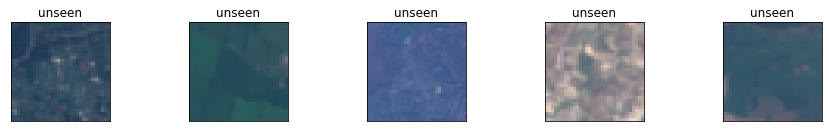

In [16]:
from torchvision.datasets.lsun import string
import glob
import cv2
eurosat_data = torchvision.datasets.EuroSAT("/content", download = True)
class EuroSAT_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, CIFAR_dataset, split):
      self.images = glob.glob(os.path.join(root, "2750", "*", "*.jpg"))[:6000]  
      self.labels = [0] * len(self.images) 
      
      self.transform = transforms.Compose([transforms.ToPILImage(), 
                                           transforms.Resize(32), 
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean, std)])  

      images, targets = CIFAR_dataset.data, CIFAR_dataset.targets
      img2targets = list(zip(images, targets))
      
      for v in img2targets:
        img, target = v
        if target < split: 
          self.images.append(img) # 1 is seen
          self.labels.append(1)

    def __getitem__(self, i):
       if type(self.images[i]) != str: 
         image = self.images[i]
       else: 
        image = cv2.cvtColor(cv2.imread(self.images[i]), cv2.COLOR_RGB2BGR)
       image = self.transform(image)

       return image, self.labels[i]

    def __len__(self):
      return len(self.images)

euro_dataset = EuroSAT_Dataset("/content/eurosat", testset,6)
euro_dl_cifar = torch.utils.data.DataLoader(euro_dataset, batch_size = 32, shuffle = True)

mixed_classes = ["unseen", "seen"]
euro_dl_cifar_iter = iter(euro_dl_cifar)
images, targets = next(euro_dl_cifar_iter)

images = images.numpy()
images -= images.min() 
images /= images.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)     
        

class Generator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ngf=64, nc=512):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.Conv2d( self.nz, self.ngf * 8, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (self.ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (self.ngf*4) x 8 x 8
            nn.Conv2d( self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (self.ngf*2) x 16 x 16
            nn.Conv2d( self.ngf * 2, self.ngf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(True),
            # state size. (self.ngf) x 32 x 32
            nn.Conv2d( self.ngf*4, self.nc, 1, 1, 0, bias=True),
            #nn.Tanh()
            # state size. (self.nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu=1, nc=2048, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

#Pre-Trained K Way classification

In [ ]:
class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    def __init__(self, num_layers=18, isPretrained=False, isGrayscale=False, embDimension=128, poolSize=4):
        super(ResnetEncoder, self).__init__()
        self.path_to_model = '../models'
        self.num_ch_enc = np.array([64, 64, 128, 256, 512])
        self.isGrayscale = isGrayscale
        self.isPretrained = isPretrained
        self.embDimension = embDimension
        self.poolSize = poolSize
        self.featListName = ['layer0', 'layer1', 'layer2', 'layer3', 'layer4']
        
        resnets = {
            18: models.resnet18, 
            34: models.resnet34,
            50: models.resnet50, 
            101: models.resnet101,
            152: models.resnet152}
        
        resnets_pretrained_path = {
            18: 'resnet18-5c106cde.pth', 
            34: 'resnet34.pth',
            50: 'resnet50.pth',
            101: 'resnet101.pth',
            152: 'resnet152.pth'}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(
                num_layers))

        self.encoder = resnets[num_layers]()
        
        if self.embDimension>0:
            self.encoder.linear =  nn.Linear(self.num_ch_enc[-1], self.embDimension)
        
        if self.isPretrained:
            print("using pretrained model")
            self.encoder.load_state_dict(
                torch.load(os.path.join(self.path_to_model, resnets_pretrained_path[num_layers])))
        
        #if self.isGrayscale:
        #    self.encoder.conv1 = nn.Conv2d(
        #        1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #else:
        #    self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        
        x = self.encoder.conv1(input_image)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        self.features.append(x)
        
        #x = self.encoder.layer1(self.encoder.maxpool(x)) # 
        x = self.encoder.layer1(x) # self.encoder.maxpool(x)
        self.features.append(x)
        #print('layer1: ', x.shape)
        
        x = self.encoder.layer2(x)
        self.features.append(x)
        #print('layer2: ', x.shape)
        
        x = self.encoder.layer3(x) 
        self.features.append(x)
        #print('layer3: ', x.shape)       
        
        x = self.encoder.layer4(x)
        self.features.append(x)
        #print('layer4: ', x.shape)
        
        x = F.avg_pool2d(x, self.poolSize)
        #print('global pool: ', x.shape)
        
        x = x.view(x.size(0), -1)
        #print('reshape: ', x.shape)
        
        if self.embDimension>0:
            x = self.encoder.linear(x)
        #print('final: ', x.shape)
        return x
    

In [ ]:
def build_max_model(kway_model_path): 

  resnet50 = ResnetEncoder(num_layers = 50, embDimension = -1, poolSize=2)
  del resnet50.encoder.fc

  state_dict = torch.load(kway_model_path)
  new_keys = dict()
  for k in list(state_dict.keys()): 
    new_keys[k] = "encoder." + k
  
  modified_state_dict = dict((new_keys[key], value) for (key, value) in state_dict.items())

  del modified_state_dict['encoder.fc.weight']
  del modified_state_dict['encoder.fc.bias']

  resnet50.load_state_dict(modified_state_dict)
  resnet50.eval()

  return resnet50

resnet50 = build_max_model("/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth")

# Pre-Trained Discriminator

In [ ]:
netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=nc).to(device)
netD = Discriminator().to(device)
# netD = Discriminator(ngpu=ngpu, nc=nc, ndf=ndf).to(device)


# Handle multi-gpu if desired
if ('cuda' in device) and (ngpu > 1): 
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)


if ('cuda' in device) and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(device)

cuda


In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)
print(fake.size()) 
predLabel = netD(fake)

print(noise.shape, fake.shape, predLabel.shape)

torch.Size([32, 2048, 1, 1])
torch.Size([32, 64, 1, 1]) torch.Size([32, 2048, 1, 1]) torch.Size([32, 1, 1, 1])


# Once you have the fake [16, 2048, 1, 1] from generated fakes and [16, 2048, 1, 1] from data loader

concat them to [32, 2048, 1, 1]

In [ ]:
fake.size()

torch.Size([16, 2048, 1, 1])

setup training
-----------

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish open and close labels
close_label = 1
open_label = 0

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0


# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr/1.5, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
a = torch.tensor(6)
a = a.cuda()

training GAN
-----------

In [ ]:
images, labels = next(iter(train_OpenSetSVHNLoader))

In [ ]:
images.size()

torch.Size([32, 3, 32, 32])

In [ ]:
from tarfile import XHDTYPE
# Training Loop

# Lists to keep track of progress
lossList = []
G_losses = []
D_losses = []

fake_BatchSize = int(ganBatchSize/2)
open_BatchSize = ganBatchSize



tmp_weights = torch.full((1,), 1, device=device).to(float)
tmp_weights[-fake_BatchSize:] *= weight_adversarialLoss
criterionD = nn.BCELoss(weight=tmp_weights)

netG.to(device)
netD.to(device) 
resnet50.to(device) 

print("Starting Training Loop...")
# For each epoch
openPixImgCount = 0
# openPix_sampler = iter(openPix_dataloader)
for epoch in range(num_epochs):
    train_OpenSet_SVHNiter = iter(train_OpenSetSVHNLoader)
    # For each batch in the dataloader
    for i, (images, labels) in enumerate(train_Closed_CIFARLoader):
      
      # Trained Closed CIFAR is smaller than open SVHN
      open_images, open_labels = next(train_OpenSet_SVHNiter)

      ''' ADDED CODE'''
      noise_images = torch.from_numpy(np.random.normal(0, 1, size = (16, 3, 32, 32,))).float()
      noise_labels = open_labels.clone()

      images = torch.cat((images, noise_images), dim = 0)
      labels = torch.cat((labels, noise_labels), dim = 0)
      '''END'''

      images = torch.cat((images, open_images), dim = 0)
      labels = torch.cat((labels, open_labels), dim = 0)

      images = images.to(device)
      labels = labels.to(device)

      # Features to K Way classification Model (6 way classification) backbone 
      image_features = resnet50(images)[:, :, None, None]

      # generate fake images      
      noise = torch.randn(fake_BatchSize, nz, 1, 1, device=device)
      # Generate fake image batch with G
      label_fake = torch.full((fake_BatchSize,), fake_label, device=device)
      feat_fakeset = netG(noise)

      X = torch.cat((image_features, feat_fakeset), 0)
      label_total = F.pad(labels, pad = (0, int(ganBatchSize/2)), mode = 'constant', value = 0)[:, None, None]


      # X2label = list(zip(X, label_total))
      # random.shuffle(X2label)

      # X, label_total = list(zip(*X2label))
      # X, label_total = list(X), list(label_total)
      # X = torch.stack(X)
      # label_total = torch.stack(label_total)[:, None, None]

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      # using close&open&fake data to update D
      netD.zero_grad()
      output = netD(X).squeeze(-1)

      # output = torch.sigmoid(output)
      lossD = criterionD(output, label_total.float())
      lossD.backward(retain_graph=True)
      optimizerD.step()
      errD = lossD.mean().item()      
          
          
      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      netG.zero_grad()
      label_fakeclose = torch.full((fake_BatchSize,), close_label, device=device)  

      # Since we just updated D, perform another forward pass of all-fake batch through D
      output = netD(feat_fakeset).view(-1)
      # output = torch.sigmoid(output)

      # Calculate G's loss based on this output
      lossG = criterion(output, label_fakeclose.float())
      # Calculate gradients for G
      lossG.backward()
      errG = lossG.mean().item()
      # Update G
      optimizerG.step()
          
      # Save Losses for plotting later
      G_losses.append(errG)
      D_losses.append(errD)
      
      
      # Output training stats
      if i % 100 == 0:
          print('[%d/%d][%d/%d]\t\tlossG: %.4f, lossD: %.4f'
                % (epoch, num_epochs, i, len(train_Closed_CIFARLoader), 
                    errG, errD))
            
            
    cur_model_wts = copy.deepcopy(netD.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.classifier'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)
    cur_model_wts = copy.deepcopy(netG.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.GNet'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)

Starting Training Loop...
[0/20][0/469]		lossG: 0.7363, lossD: 0.1314
[0/20][100/469]		lossG: 0.7520, lossD: 0.0841
[0/20][200/469]		lossG: 0.7669, lossD: 0.0746
[0/20][300/469]		lossG: 0.7716, lossD: 0.0625
[0/20][400/469]		lossG: 0.7984, lossD: 0.0567
[1/20][0/469]		lossG: 0.8140, lossD: 0.0551
[1/20][100/469]		lossG: 0.8016, lossD: 0.0505
[1/20][200/469]		lossG: 0.8088, lossD: 0.0507
[1/20][300/469]		lossG: 0.8367, lossD: 0.0335
[1/20][400/469]		lossG: 0.8278, lossD: 0.0487
[2/20][0/469]		lossG: 0.8117, lossD: 0.0353
[2/20][100/469]		lossG: 0.8202, lossD: 0.0323
[2/20][200/469]		lossG: 0.7802, lossD: 0.0360
[2/20][300/469]		lossG: 0.7891, lossD: 0.0382
[2/20][400/469]		lossG: 0.7786, lossD: 0.0444
[3/20][0/469]		lossG: 0.7826, lossD: 0.0431
[3/20][100/469]		lossG: 0.7567, lossD: 0.0367
[3/20][200/469]		lossG: 0.7651, lossD: 0.0344
[3/20][300/469]		lossG: 0.7943, lossD: 0.0386
[3/20][400/469]		lossG: 0.7200, lossD: 0.0309
[4/20][0/469]		lossG: 0.7470, lossD: 0.0301
[4/20][100/469]		l

# Evaluate OpenGAN Discriminator 

In [ ]:
# Load Trained Discriminator

def load_discriminator(model_path): 
  discriminator = Discriminator()
  state_dict = torch.load(model_path)
  discriminator.load_state_dict(state_dict)
  discriminator.eval()
  discriminator.to(device) 

  return discriminator 


In [ ]:
net = load_discriminator("/content/epoch-45.classifier")

In [ ]:
tmg = torch.tensor(imgs)

In [ ]:
tmg_features = resnet50(tmg)[:, :, None, None]
tmg_features = tmg_features.cuda()
out = net(tmg_features)

In [ ]:
out.view(-1)

tensor([0.5831, 0.8636, 0.4256, 0.3802, 0.4229, 0.8510, 0.3527, 0.3119, 0.4590,
        0.4303, 0.9706, 0.2737, 0.3005, 0.3084, 0.6476, 0.3132],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
targets

tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0])

In [ ]:
out = out > 0.3

In [ ]:
out[:, 0, 0, 0].to(int)

tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')

In [26]:
# Metrics: 

def F_measure(preds, labels, openset=False, theta=None):
  if openset:
      # f1 score for openset evaluation
      true_pos = 0.
      false_pos = 0.
      false_neg = 0.        
      for i in range(len(labels)):
          true_pos += 1 if preds[i] == labels[i] and labels[i] != -1 else 0
          false_pos += 1 if preds[i] != labels[i] and labels[i] != -1 else 0
          false_neg += 1 if preds[i] != labels[i] and labels[i] == -1 else 0

      precision = true_pos / (true_pos + false_pos)
      recall = true_pos / (true_pos + false_neg)
      return 2 * ((precision * recall) / (precision + recall + 1e-12))
  else: # Regular f1 score        
      return f1_score(labels, preds, average='macro')

def roc(scores, labels, **kwargs):
    """Returns the ROC curve and the area under it. The implementation assumes binary classification

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    if 'gt_shift' in kwargs:
        labels = labels - kwargs['gt_shift']
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = roc_auc_score(labels, scores)
    roc_data = {
        'tp': list(tpr),
        'fp': list(fpr),
        'thresh': list(thresholds),
        'auc': auc_score,
    }
    return roc_data


def pr(scores, labels, **kwargs):
    """Returns the PR curve and the area under it. The implementation assumes binary classification

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    auc_score = auc(recall, precision)

    pr_data = {
        'precision': list(precision),
        'recall': list(recall),
        'thresh': list(thresholds),
        'auc': auc_score,
    }
    return pr_data

def ccr(scores, labels, **kwargs):
    """Returns the CCR VS FPR curve and returns the area under it.

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    if 'gt_shift' in kwargs:
        labels = labels - kwargs['gt_shift']
    max_indices = np.argmax(scores, axis=1) # Nx(K+1)
    max_values = np.take_along_axis(scores, max_indices[:, None], axis=1)
    data = list(zip([elem[0] for elem in max_values], max_indices, labels))
    data.sort(key=lambda x: x[0], reverse=True)
    cls_count = len(scores[0])
    unknown_count = len(np.where(labels == 0)[0])  # Unknown class is 0
    known_count = len(labels) - unknown_count
    fp = [0]
    tp = [0]
    thresholds = list()
    n = 0
    n_above_unknown = 0
    curr_unknown_prob = 1
    for score, pred_cls, gt_cls in data:
        if gt_cls == 0:
            curr_unknown_prob = score
            thresholds.append(score)
            fp.append(fp[-1] + 1)
            tp.append(n)
        elif pred_cls == gt_cls:
            n_above_unknown += 1
            if score < curr_unknown_prob:
                n = n_above_unknown
    fpr = np.asarray(fp[1:]) / unknown_count
    ccr = np.asarray(tp[1:]) / known_count
    auc_score = auc(fpr, ccr)
    ccr_data = {
        'ccr': list(ccr),
        'fpr': list(fpr),
        'thresh': thresholds,
        'auc': auc_score,
    }
    return ccr_data

In [ ]:
def evaluate_bn_roc_pr(dis_model_path, kway_model_path, data_loader):

  disc = load_discriminator(dis_model_path)
  kway = build_max_model(kway_model_path)


  '''Only will find ROC and PR Metrics'''

  disc = disc.cuda()
  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  for data, target in tqdm(data_loader): 
      data, target = data.cuda(), target.cuda()
      disc.eval()

      #forward
      x_feat = kway(data.float())[:, :, None, None]
      out = disc(x_feat)
      out = out.view(-1)

      assert out.size(0) == target.size(0)

      stacked_outs.extend(out.tolist()) 
      stacked_targets.extend(target.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/20epochOpenGANCIFARKwayOct6th.pth", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", test_newDatasetAndCIFARLoader)


100%|██████████| 375/375 [00:07<00:00, 52.57it/s]



ROC AU value: 89.1806125%
PR AU value: 88.36768593169586%


(89.1806125, 88.36768593169586)

In [ ]:
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/20epochOpenGANCIFARKwayOct6th.pth", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", euro_dl_cifar)


100%|██████████| 375/375 [00:09<00:00, 41.63it/s]



ROC AU value: 93.26816666666666%
PR AU value: 94.91482321664635%


(93.26816666666666, 94.91482321664635)

In [ ]:
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/20epochOpenGANCIFARKwayOct6th.pth", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth",  test_MNISTAndCIFARLoader)



100%|██████████| 375/375 [00:08<00:00, 45.16it/s]



ROC AU value: 35.738837499999995%
PR AU value: 47.55342064738276%


(35.738837499999995, 47.55342064738276)

In [ ]:
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/20epochOpenGANCIFARKwayOct6th.pth", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", uniformDisLoader)

100%|██████████| 7/7 [00:00<00:00, 40.66it/s]



ROC AU value: 94.6%
PR AU value: 96.93258016237776%


(94.6, 96.93258016237776)

In [ ]:
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/20epochOpenGANCIFARKwayOct6th.pth", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", normalDisLoader)


100%|██████████| 7/7 [00:00<00:00, 38.37it/s]



ROC AU value: 98.78%
PR AU value: 98.9326872099155%


(98.78, 98.9326872099155)

In [ ]:

evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-20.classifier", "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth", test_mixedCIFARLoader )


100%|██████████| 313/313 [00:05<00:00, 53.73it/s]



ROC AU value: 39.630660416666665%
PR AU value: 53.75385205765107%


(39.630660416666665, 53.75385205765107)

In [ ]:
evaluate_bn_roc_pr("/content/epoch-50.classifier", "/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth", test_MNISTAndCIFARLoader)

100%|██████████| 750/750 [00:18<00:00, 41.49it/s]



ROC AU value: 48.287575%
PR AU value: 55.38754950376418%


(48.287575, 55.38754950376418)

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-20.classifier", "/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth",  uniformDisLoader)

100%|██████████| 7/7 [00:00<00:00, 39.50it/s]



ROC AU value: 63.85999999999999%
PR AU value: 79.14051109216929%


(63.85999999999999, 79.14051109216929)

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-5.classifier", "/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth",  normalDisLoader)

100%|██████████| 7/7 [00:00<00:00, 40.66it/s]



ROC AU value: 64.82%
PR AU value: 73.54019283849867%


(64.82, 73.54019283849867)

In [ ]:
evaluate_bn_roc_pr("/content/epoch-50.classifier", "/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth", normalDisLoader)

100%|██████████| 7/7 [00:00<00:00, 39.29it/s]



ROC AU value: 69.61%
PR AU value: 73.82384981223737%


(69.61, 73.82384981223737)

# New Validation Setup for Heavy Transforms and TinyImageNet

In [ ]:
class SplitCIFAR(torch.utils.data.Dataset):
    def __init__(self, data, targets, split, mode, transformFunc, iaa_compat = False, rain = False):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        img2targets = list(zip(data, targets))
        self.data = list()
        self.iaa_compat = iaa_compat
        self.rain = rain

        if mode == "train": 
          for v in img2targets:
            _, target = v
            if target < split: 
              self.data.append(v)
        elif mode == "test": 
          for v in img2targets: 
            _, target = v 
            if target >= split: 
              self.data.append(v)
        else: 
          raise ValueError("Not a mode")
        
        self.transformFunc = transformFunc

        if self.iaa_compat: 
          self.contents = ["UNSEEN"] * (len(self.data) // 2)
          left = len(self.data) - len(self.contents)
          self.contents.extend((["SEEN"] * left))

          assert len(self.contents) == len(self.data)

          self.normal_transform = transforms.Compose([
                                                      transforms.ToPILImage(), 
                                                      transforms.ToTensor(), 
                                                      transforms.Normalize(mean, std)])                             
    def __getitem__(self, i):
       img, target = self.data[i]
       if self.iaa_compat: 
         if self.contents[i] == "UNSEEN":
           img = self.transformFunc(image = img)
           target = torch.tensor(0, dtype = int)
         else: 
           '''SEEN data'''
           if self.rain: 
             img = self.transformFunc(image = img)
           target = torch.tensor(1, dtype = int)

         img = self.normal_transform(img)
         return img, target 
       else: 
         img = self.transformFunc(img)
         return img, target

    def __len__(self):
        return len(self.data)

In [ ]:
def evaluate_bn_roc_pr(dis_model_path, kway_model_path, openDataset, closedDataset):

  disc = load_discriminator(dis_model_path)
  kway = build_max_model(kway_model_path)

  openDataLoader = torch.utils.data.DataLoader(openDataset, batch_size = 32, shuffle = True)
  closedDataLoader = torch.utils.data.DataLoader(closedDataset, batch_size = 32, shuffle = True)

  if len(openDataset) > len(closedDataset): 
    for_loop_loader = "closedDataLoader"
    iter_loader = "openDataLoader"
  else: 
    for_loop_loader = "openDataLoader"
    iter_loader = "closedDataLoader"
  
  print("For Loop Loader is {}".format(for_loop_loader))
  print("Iter Loop Loader is {}".format(iter_loader))

  '''Only will find ROC and PR Metrics'''

  disc = disc.cuda()
  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  dateiter = iter(eval(iter_loader))
  for for_data, for_targets in tqdm(eval(for_loop_loader)): 
      iter_data, iter_targets = next(dateiter)
      if for_loop_loader=="closedDataLoader": 
        for_targets = torch.ones(*for_targets.size())
        iter_targets = torch.zeros(*iter_targets.size())
      else: 
        for_targets = torch.zeros(*for_targets.size())
        iter_targets = torch.ones(*iter_targets.size())
      iter_data, iter_targets = iter_data.cuda(), iter_targets.cuda()
      for_data, for_targets = for_data.cuda(), for_targets.cuda()
      
      data = torch.cat((iter_data, for_data), 0)
      target = torch.cat((iter_targets, for_targets), 0)

      disc.eval()

      #forward
      x_feat = kway(data.float())[:, :, None, None]
      out = disc(x_feat)
      out = out.view(-1)

      assert out.size(0) == target.size(0)

      stacked_outs.extend(out.tolist()) 
      stacked_targets.extend(target.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
transforms_noisyOE = iaa.Sequential([
   iaa.Fliplr(0.5),
   iaa.pillike.EnhanceContrast(),
   iaa.GaussianBlur(sigma=(0.1, 2)),
   iaa.Rain(speed=(0.5, 0.9))
])

# transforms_noisyOE = iaa.Sequential([
#    iaa.pillike.EnhanceContrast(),
#    iaa.GaussianBlur(sigma=(0.1, 1))
# ])



heavy_Transforms_CIFAR = SplitCIFAR(testset.data, testset.targets, 6, "train", transforms_noisyOE, iaa_compat = True, rain = True)

In [ ]:
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/20epochOpenGANCIFARKwayOct6th.pth", 
                   "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", 
                   heavy_Transforms_CIFAR, test_Closed_CIFAR)

For Loop Loader is openDataLoader
Iter Loop Loader is closedDataLoader


100%|██████████| 188/188 [00:50<00:00,  3.69it/s]



ROC AU value: 75.62195%
PR AU value: 71.76783438587745%


(75.62195, 71.76783438587745)

In [ ]:
class Closed_TINYIMAGENET():
    def __init__(self, size=(32,32), set_name='train',
                 path_to_data='/content/tiny-imagenet-200', 
                 isAugment=True):
        
        self.path_to_data = path_to_data        
        self.mapping_name2id = {}
        self.mapping_id2name = {}
        self.mapping_name2english_name = {}
        with open(path.join(self.path_to_data, 'wnids.txt')) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=' ')
            idx = 0
            for row in csv_reader:
                if idx >= 180: 
                  break
                self.mapping_id2name[idx] = row[0]
                self.mapping_name2id[row[0]] = idx
                idx += 1
        with open(path.join(self.path_to_data, 'words.txt')) as csv_file: 
          csv_reader = csv.reader(csv_file, delimiter=' ')
          idx = 0
          for row in csv_reader:
            row = row[0].split('\t')
            self.mapping_name2english_name[row[0]] = row[1]
            idx += 1


        assert len(self.mapping_id2name) == len(self.mapping_name2id) == 180
        
        
        if set_name=='test':  set_name = 'val'
        
        self.size = size
        self.set_name = set_name
        self.path_to_data = path_to_data
        self.isAugment = isAugment
        
        self.imageNameList  = []
        self.className = []
        self.labelList = []
        self.mappingLabel2Name = dict()
        curLabel = 0

        
        if self.set_name == 'val':
            with open(path.join(self.path_to_data, 'val', 'val_annotations.txt')) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter='\t')
                line_count = 0
                for row in csv_reader:
                    if row[1] not in self.mapping_name2id: continue
                    self.imageNameList += [path.join(self.path_to_data, 'val', 'images', row[0])]
                    self.labelList += [self.mapping_name2id[row[1]]]
        else: # 'train'
            self.current_class_dir = path.join(self.path_to_data, self.set_name)
            for curClass in os.listdir(self.current_class_dir):                 
                if curClass[0]=='.':   continue
                if curClass not in self.mapping_name2id: continue
                
                curLabel = self.mapping_name2id[curClass]
                for curImg in os.listdir(path.join(self.current_class_dir, curClass, 'images')):
                    if curImg[0]=='.':    continue
                    self.labelList += [curLabel]
                    self.imageNameList += [path.join(self.path_to_data, self.set_name, curClass, 'images', curImg)]

        
        self.current_set_len = len(self.labelList)
        
        if self.set_name=='test' or self.set_name=='val' or  not self.isAugment:
            self.transform = transforms.Compose([
                transforms.RandomCrop(self.size[0], padding=4), 
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            ])            # ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        else:
            self.transform = transforms.Compose([
                transforms.RandomCrop(self.size[0], padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            ])
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curLabel = np.asarray(self.labelList[idx])
        curImage = self.imageNameList[idx]
        curImage = PIL.Image.open(curImage).convert('RGB')
        curImage = self.transform(curImage)
        
        #print(idx, curLabel)
        
        #curLabel = torch.tensor([curLabel]).unsqueeze(0).unsqueeze(0)

        return curImage, curLabel

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Unknown_Detection/tiny-imagenet-200.zip","r") as zip_ref:
    zip_ref.extractall()

In [ ]:
%cd /content/

/content


In [ ]:
testTinyImageNet = Closed_TINYIMAGENET(set_name = 'test')

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-20.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth", 
                   testTinyImageNet, test_Closed_CIFAR)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 188/188 [00:13<00:00, 13.46it/s]




ROC AU value: 39.484521830673756%
PR AU value: 41.83849643803393%


(39.484521830673756, 41.83849643803393)

# Validate Logits on EuroSAT + CIFAR

In [24]:
def build_max_model(kway_model_path): 

  resnet50 = torchvision.models.resnet50(pretrained=False)
  resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

  resnet50.load_state_dict(torch.load(kway_model_path))
  resnet50.eval()

  return resnet50

def evaluate_max_models(form, kway_model_path, data_loader): 

  net = build_max_model(kway_model_path).cuda()
  num_of_data = 0
  stacked_maxes = list()
  stacked_target = list()

  for data, target in tqdm(data_loader): 

    data, target = data.cuda(), target.cuda()
    num_of_data += data.size(0)

    #forward
    x = net(data.float())

    if form == "softmax":
      # Softmax Probability
      x = F.softmax(x, dim=1)
      assert sum(x[0]).item() > 0.99 and sum(x[0]).item() < 1.001
    
    max = torch.max(x, dim = 1).values

    stacked_maxes.extend(max.tolist())
    stacked_target.extend(target.tolist())

  
  roc_measure = roc(stacked_maxes, stacked_target)['auc'] * 100
  pr_measure = pr(stacked_maxes, stacked_target)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

def validate_logits_on_euro_cifar(kway_model_path, dataloader): 

  kway = build_max_model(kway_model_path)

  '''Only will find ROC and PR Metrics'''

  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  for images, targets in tqdm(dataloader):
    images = images.cuda()
    targets = targets.cuda()
    #forward
    x = kway(images.float())
    
    max = torch.max(x, dim = 1).values

    stacked_outs.extend(max.tolist()) 
    stacked_targets.extend(targets.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [27]:
validate_logits_on_euro_cifar("/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", euro_dl_cifar)

100%|██████████| 375/375 [00:08<00:00, 44.64it/s]



ROC AU value: 77.59881388888888%
PR AU value: 84.05187095072135%


(77.59881388888888, 84.05187095072135)